# Chapter 3 Introductory Examples

## Implied Volatilities

Main idea: backsolve implied volatility by [BSM Model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)

$$ C(S_t,K,t,T,r,\sigma) = S_t N(d_1) - e^{-r(T-t)}K  N(d_2) $$

$$ N(z) = {1 \over \sqrt{2 \pi}} \int_{-\infty}^{z} e^{-{1\over{2}}x^2} dx $$

The above formula can be computed in Excel with `=NORM.S.DIST(z,TRUE)`, the flag `TRUE` indicates the use of the [cumulative distribution function](https://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function), as opposed to FALSE, which indicates the use of the [probability density function](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution), which is:

$$ N'(z) = {1 \over \sqrt{2 \pi}} e^{-{1\over{2}}z^2} $$

$$ d_1 =  \frac{ \frac{S_t}{K} + (r + \frac{\sigma^2}{2})(T-t) } {\sigma \sqrt {T-t}}  $$

$$ d_2 =  \frac{ \frac{S_t}{K} + (r - \frac{\sigma^2}{2})(T-t) } {\sigma \sqrt {T-t}}  $$

if the option price  $C^*$ is given by the market then $\sigma_{imp}$ is the implied volatility

$$ C(S_t,K,t,T,r,\sigma_{imp}) = C^* $$

Solving this numerically via the [Newton algorithm](https://en.wikipedia.org/wiki/Newton%27s_method)
$$ \sigma_{imp_{n+1}}  =  \sigma_{imp_{n}} - \frac{C(\sigma_{imp_{n}}) - C^*}{C'(\sigma_{imp_{n}})} $$

Where  $ C' = {\frac{\partial C}{\partial\sigma}}  $ , also called [Vega](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#The_Greeks), which is:

$$ \frac{\partial C(S_t,K,t,T,r,\sigma)}{\partial \sigma} = S_t N'(d_1)  \sqrt {T-t}$$

Note that in the above formula we're using the probability density function


##### Translating formulas to python code

In [1]:
##
# Valuation of European call options in Black-Scholes-Merton model
# incl. Vega function and implied volatility estimation
# bsm_functions.py
#
# Analytical Black-Scholes-Merton (BSM) Formula
def bsm_call_value(S0, K, T, r, sigma):
    '''
    Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0 : float
    initial stock/index level
    K : float
    strike price
    T : float
    maturity date (in year fractions)
    r : float
    constant risk-free short rate
    sigma : float
    volatility factor in diffusion term
    Returns
    =======
    value : float
    present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0)- K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    # stats.norm.cdf —> cumulative distribution function for normal distribution
    return value

In [2]:
def bsm_vega(S0, K, T, r, sigma):
    '''
    Vega of European option in BSM model.
    Parameters
    ==========
    S0 : float
    initial stock/index level
    K : float
    strike price
    T : float
    maturity date (in year fractions)
    r : float
    constant risk-free short rate
    sigma : float
    volatility factor in diffusion term
    Returns
    =======
    vega : float
    partial derivative of BSM formula with respect
    to sigma, i.e. Vega
    ''' 
    from math import log, sqrt
    from scipy import stats
    S0 = float(S0)
    d1 = log(S0 / K) + (r + 0.5 * sigma ** 2) * T / (sigma * sqrt(T))
    # stats.norm.ddf -> probability density function
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [3]:
# Implied volatility function
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100, tolerance=0.0000000000001):
    '''
    Implied volatility of European call option in BSM model.
    Parameters
    ==========
    S0 : float
    initial stock/index level
    K : float
    strike price
    T : float
    maturity date (in year fractions)
    r : float
    constant risk-free short rate
    sigma_est : float
    estimate of impl. volatility
    it : integer
    number of iterations
    Returns
    =======
    simga_est : float
    numerically estimated implied volatility
    '''
    for i in range(it):
        sigma_old =  sigma_est
        vega =  bsm_vega(S0, K, T, r, sigma_est) 
        if vega != 0 :
            sigma_est =  sigma_est - ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / vega)
        if abs(sigma_est - sigma_old ) < tolerance:
            break
    return sigma_est

### Simple Example

For [example](https://en.wikipedia.org/wiki/Implied_volatility#Example), a European call option, $C_{XYZ}$, on one share of non-dividend-paying XYZ Corp. The option is struck at 50 and expires in 32 days. The risk-free interest rate is 5%. XYZ stock is currently trading at 51.25 and the current market price of $C_{XYZ}$ is 2.00

In [4]:
K = 50
T = 32/365
r = 0.05
S0 = 51.25 
C0 = 2.00

In [5]:
#computing implied volatility
imp_vol =  bsm_call_imp_vol(S0, K, T, r, C0, 1.0)
print('Implied volatility is: ' , imp_vol *100 ,'%')

Implied volatility is:  18.6922843476 %


to test the above formula, we can just use the BSM formula:

In [6]:
bsm_call_value(S0, K, T, r, imp_vol)

2.0000000000000497

So we got back the call value, this validates the algorithm for implied volatility for european call options

### Example using data feed

In [7]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from math import log, sqrt
from scipy import stats
import datetime

In [8]:
ticker = 'GOOG'
stock  = web.Options(ticker, 'yahoo')
option_chain = stock.get_all_data()

In [9]:
option_chain.head()

Last    Bid    Ask    Chg  \
Strike Expiry     Type Symbol                                             
340.0  2018-01-19 call GOOG180119C00340000  685.40  680.9  685.0  685.4   
                  put  GOOG180119P00340000    0.20    0.0    0.4    0.0   
350.0  2018-01-19 call GOOG180119C00350000  691.50  712.0  715.8    0.0   
                  put  GOOG180119P00350000    0.05    0.0    0.1    0.0   
360.0  2018-01-19 call GOOG180119C00360000  677.33  666.0  670.9    0.0   

                                              PctChg    Vol  Open_Int  \
Strike Expiry     Type Symbol                                           
340.0  2018-01-19 call GOOG180119C00340000       inf    1.0      83.0   
                  put  GOOG180119P00340000  0.000000   17.0     347.0   
350.0  2018-01-19 call GOOG180119C00350000  0.000000    1.0    1192.0   
                  put  GOOG180119P00350000  0.000000    2.0     472.0   
360.0  2018-01-19 call GOOG180119C00360000  0.000000  200.0      19.0   

                                                  IV  Root  IsNonstandard  \
Strike Expiry     Type Symbol                                               
340.0  2018-01-19 call GOOG180119C00340000  0.000010  GOOG          False   
                  put  GOOG180119P00340000  1.346683  GOOG          False   
350.0  2018-01-19 call GOOG180119C00350000  1.677004  GOOG          False   
                  put  GOOG180119P00350000  1.160160  GOOG          False   
360.0  2018-01-19 call GOOG180119C00360000  0.000010  GOOG          False   

                                           Underlying  Underlying_Price  \
Strike Expiry     Type Symbol                                             
340.0  2018-01-19 call GOOG180119C00340000       GOOG           1064.19   
                  put  GOOG180119P00340000       GOOG           1064.19   
350.0  2018-01-19 call GOOG180119C00350000       GOOG           1064.19   
                  put  GOOG180119P00350000       GOOG           1064.19   
360.0  2018-01-19 call GOOG180119C00360000       GOOG           1064.19   

                                                    Quote_Time  \
Strike Expiry     Type Symbol                                    
340.0  2018-01-19 call GOOG180119C00340000 2017-12-15 21:00:00   
                  put  GOOG180119P00340000 2017-12-15 21:00:00   
350.0  2018-01-19 call GOOG180119C00350000 2017-12-15 21:00:00   
                  put  GOOG180119P00350000 2017-12-15 21:00:00   
360.0  2018-01-19 call GOOG180119C00360000 2017-12-15 21:00:00   

                                               Last_Trade_Date  \
Strike Expiry     Type Symbol                                    
340.0  2018-01-19 call GOOG180119C00340000 2017-11-29 16:03:41   
                  put  GOOG180119P00340000 2017-11-20 14:32:28   
350.0  2018-01-19 call GOOG180119C00350000 2017-12-13 19:00:16   
                  put  GOOG180119P00350000 2017-10-19 19:33:16   
360.0  2018-01-19 call GOOG180119C00360000 2017-11-08 17:08:27   

                                                                                         JSON  
Strike Expiry     Type Symbol                                                                  
340.0  2018-01-19 call GOOG180119C00340000  {'contractSymbol': 'GOOG180119C00340000', 'str...  
                  put  GOOG180119P00340000  {'contractSymbol': 'GOOG180119P00340000', 'str...  
350.0  2018-01-19 call GOOG180119C00350000  {'contractSymbol': 'GOOG180119C00350000', 'str...  
                  put  GOOG180119P00350000  {'contractSymbol': 'GOOG180119P00350000', 'str...  
360.0  2018-01-19 call GOOG180119C00360000  {'contractSymbol': 'GOOG180119C00360000', 'str...

In [10]:
#only work with call options
ix1 = option_chain.index.get_level_values('Type').isin(['call'])
option_chain = option_chain[ix1]
option_chain.head()

Last    Bid    Ask    Chg  \
Strike Expiry     Type Symbol                                             
340.0  2018-01-19 call GOOG180119C00340000  685.40  680.9  685.0  685.4   
350.0  2018-01-19 call GOOG180119C00350000  691.50  712.0  715.8    0.0   
360.0  2018-01-19 call GOOG180119C00360000  677.33  666.0  670.9    0.0   
370.0  2018-01-19 call GOOG180119C00370000  478.60  605.5  609.9    0.0   
380.0  2018-01-19 call GOOG180119C00380000  599.93  607.0  611.6    0.0   

                                              PctChg    Vol  Open_Int  \
Strike Expiry     Type Symbol                                           
340.0  2018-01-19 call GOOG180119C00340000       inf    1.0      83.0   
350.0  2018-01-19 call GOOG180119C00350000  0.000000    1.0    1192.0   
360.0  2018-01-19 call GOOG180119C00360000  0.000000  200.0      19.0   
370.0  2018-01-19 call GOOG180119C00370000  0.000000    5.0      12.0   
380.0  2018-01-19 call GOOG180119C00380000  0.000000    2.0      43.0   

                                                  IV  Root  IsNonstandard  \
Strike Expiry     Type Symbol                                               
340.0  2018-01-19 call GOOG180119C00340000  0.000010  GOOG          False   
350.0  2018-01-19 call GOOG180119C00350000  1.677004  GOOG          False   
360.0  2018-01-19 call GOOG180119C00360000  0.000010  GOOG          False   
370.0  2018-01-19 call GOOG180119C00370000  0.000010  GOOG          False   
380.0  2018-01-19 call GOOG180119C00380000  0.000010  GOOG          False   

                                           Underlying  Underlying_Price  \
Strike Expiry     Type Symbol                                             
340.0  2018-01-19 call GOOG180119C00340000       GOOG           1064.19   
350.0  2018-01-19 call GOOG180119C00350000       GOOG           1064.19   
360.0  2018-01-19 call GOOG180119C00360000       GOOG           1064.19   
370.0  2018-01-19 call GOOG180119C00370000       GOOG           1064.19   
380.0  2018-01-19 call GOOG180119C00380000       GOOG           1064.19   

                                                    Quote_Time  \
Strike Expiry     Type Symbol                                    
340.0  2018-01-19 call GOOG180119C00340000 2017-12-15 21:00:00   
350.0  2018-01-19 call GOOG180119C00350000 2017-12-15 21:00:00   
360.0  2018-01-19 call GOOG180119C00360000 2017-12-15 21:00:00   
370.0  2018-01-19 call GOOG180119C00370000 2017-12-15 21:00:00   
380.0  2018-01-19 call GOOG180119C00380000 2017-12-15 21:00:00   

                                               Last_Trade_Date  \
Strike Expiry     Type Symbol                                    
340.0  2018-01-19 call GOOG180119C00340000 2017-11-29 16:03:41   
350.0  2018-01-19 call GOOG180119C00350000 2017-12-13 19:00:16   
360.0  2018-01-19 call GOOG180119C00360000 2017-11-08 17:08:27   
370.0  2018-01-19 call GOOG180119C00370000 2017-06-03 03:49:52   
380.0  2018-01-19 call GOOG180119C00380000 2017-10-06 19:50:15   

                                                                                         JSON  
Strike Expiry     Type Symbol                                                                  
340.0  2018-01-19 call GOOG180119C00340000  {'contractSymbol': 'GOOG180119C00340000', 'str...  
350.0  2018-01-19 call GOOG180119C00350000  {'contractSymbol': 'GOOG180119C00350000', 'str...  
360.0  2018-01-19 call GOOG180119C00360000  {'contractSymbol': 'GOOG180119C00360000', 'str...  
370.0  2018-01-19 call GOOG180119C00370000  {'contractSymbol': 'GOOG180119C00370000', 'str...  
380.0  2018-01-19 call GOOG180119C00380000  {'contractSymbol': 'GOOG180119C00380000', 'str...

In [11]:
# adding a new column to be populate during the iteration this is the time to expiration
option_chain['TTE']           = pd.Series(np.zeros(len(option_chain)), index=option_chain.index)
option_chain['implied_vol']   = pd.Series(np.zeros(len(option_chain)), index=option_chain.index)
option_chain['r']             = pd.Series(np.zeros(len(option_chain)), index=option_chain.index)
option_chain['rel_strike']    = pd.Series(np.zeros(len(option_chain)), index=option_chain.index)
#computing the relative strike
option_chain['rel_strike']    = option_chain.index.get_level_values('Strike') / option_chain['Underlying_Price']

#iterate over the dataframe to populate the implied volatility
for index, row in option_chain.iterrows():
    K = index[0]
    expiry = index[1]
    TTE  = (expiry-row['Quote_Time']).days/365.0
    r = 0.015
    S0 = row['Underlying_Price']
    C0 = row['Bid']
    option_chain.loc[index,['TTE']] = TTE
    option_chain.loc[index,['r']]   = r
    option_chain.loc[index,['implied_vol']]   = bsm_call_imp_vol(S0, K, T, r, C0, 0.01)



C:\Users\jegar\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars


In [12]:
option_chain.tail()

Last   Bid   Ask    Chg  \
Strike Expiry     Type Symbol                                          
1560.0 2019-06-21 call GOOG190621C01560000  12.32   7.5  17.0   0.32   
       2020-01-17 call GOOG200117C01560000  19.10  19.0  24.0  19.10   
1580.0 2019-01-18 call GOOG190118C01580000   4.30   4.3   8.0   0.00   
       2019-06-21 call GOOG190621C01580000  11.00   6.0  15.8   0.80   
       2020-01-17 call GOOG200117C01580000  21.30  20.0  24.0   0.00   

                                              PctChg   Vol  Open_Int  \
Strike Expiry     Type Symbol                                          
1560.0 2019-06-21 call GOOG190621C01560000  2.666664  12.0      20.0   
       2020-01-17 call GOOG200117C01560000  0.000000   1.0      11.0   
1580.0 2019-01-18 call GOOG190118C01580000  0.000000   1.0       1.0   
       2019-06-21 call GOOG190621C01580000  7.843139  10.0       9.0   
       2020-01-17 call GOOG200117C01580000  0.000000   2.0       5.0   

                                                  IV  Root  IsNonstandard  \
Strike Expiry     Type Symbol                                               
1560.0 2019-06-21 call GOOG190621C01560000  0.238693  GOOG          False   
       2020-01-17 call GOOG200117C01560000  0.223717  GOOG          False   
1580.0 2019-01-18 call GOOG190118C01580000  0.240425  GOOG          False   
       2019-06-21 call GOOG190621C01580000  0.239525  GOOG          False   
       2020-01-17 call GOOG200117C01580000  0.228577  GOOG          False   

                                           Underlying  Underlying_Price  \
Strike Expiry     Type Symbol                                             
1560.0 2019-06-21 call GOOG190621C01560000       GOOG           1064.19   
       2020-01-17 call GOOG200117C01560000       GOOG           1064.19   
1580.0 2019-01-18 call GOOG190118C01580000       GOOG           1064.19   
       2019-06-21 call GOOG190621C01580000       GOOG           1064.19   
       2020-01-17 call GOOG200117C01580000       GOOG           1064.19   

                                                    Quote_Time  \
Strike Expiry     Type Symbol                                    
1560.0 2019-06-21 call GOOG190621C01560000 2017-12-15 21:00:00   
       2020-01-17 call GOOG200117C01560000 2017-12-15 21:00:00   
1580.0 2019-01-18 call GOOG190118C01580000 2017-12-15 21:00:00   
       2019-06-21 call GOOG190621C01580000 2017-12-15 21:00:00   
       2020-01-17 call GOOG200117C01580000 2017-12-15 21:00:00   

                                               Last_Trade_Date  \
Strike Expiry     Type Symbol                                    
1560.0 2019-06-21 call GOOG190621C01560000 2017-12-15 18:31:13   
       2020-01-17 call GOOG200117C01560000 2017-12-06 20:39:51   
1580.0 2019-01-18 call GOOG190118C01580000 2017-12-16 04:51:56   
       2019-06-21 call GOOG190621C01580000 2017-12-15 20:54:50   
       2020-01-17 call GOOG200117C01580000 2017-12-12 17:46:27   

                                                                                         JSON  \
Strike Expiry     Type Symbol                                                                   
1560.0 2019-06-21 call GOOG190621C01560000  {'contractSymbol': 'GOOG190621C01560000', 'str...   
       2020-01-17 call GOOG200117C01560000  {'contractSymbol': 'GOOG200117C01560000', 'str...   
1580.0 2019-01-18 call GOOG190118C01580000  {'contractSymbol': 'GOOG190118C01580000', 'str...   
       2019-06-21 call GOOG190621C01580000  {'contractSymbol': 'GOOG190621C01580000', 'str...   
       2020-01-17 call GOOG200117C01580000  {'contractSymbol': 'GOOG200117C01580000', 'str...   

                                                 TTE  implied_vol      r  \
Strike Expiry     Type Symbol                                              
1560.0 2019-06-21 call GOOG190621C01560000  1.512329     0.814125  0.015   
       2020-01-17 call GOOG200117C01560000  2.087671     1.019509  0.015   
1580.0 2019-01-18 call GOOG190118C01580000  1.090411     0.

In [13]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
plt.figure(figsize=(20, 6))


# do a series of filters to work with recently traded option

ix1 = option_chain['implied_vol'] > 0 
ix2 = option_chain['implied_vol'] < 1
ix3 = option_chain['Vol'] > 100
#only options that were traded today
ix4 = option_chain['Last_Trade_Date'].dt.date == option_chain['Quote_Time'].dt.date
#and within a range of relativ strike (K/S)
rel_strike_range = 0.25
ix5 = option_chain['rel_strike'] > 1 - rel_strike_range
ix6 = option_chain['rel_strike'] < 1 + rel_strike_range
df_graph = option_chain[ix1 & ix2 & ix4 & ix5 & ix6]

counter = 0
for expiry in df_graph.index.levels[1]:
    ix2  = df_graph.index.get_level_values('Expiry').isin([expiry])
    data = df_graph[ix2]
    # select data for this maturity
    line1, = plt.plot(data.index.get_level_values('Strike'), data['implied_vol'], label=expiry.date().isoformat())
    plt.plot(data.index.get_level_values('Strike'), data['implied_vol'],'r.')
    plt.grid(True)
    plt.xlabel('strike')
    plt.ylabel('implied volatility of volatility')
    counter += 1
plt.legend(handler_map={line1: HandlerLine2D(numpoints = counter)})
plt.show()
    

The above graph shows the implied volatility across different expiries, the greater the expiry the greater the implied volatility and also there is a skew ([smile](https://en.wikipedia.org/wiki/Volatility_smile)) where, for call options, deep in the money 
$  {K \over S} << 1 $

### Volatility Surface
The previous graph can also be done in 3D based on this [example](https://matplotlib.org/examples/mplot3d/trisurf3d_demo.html)

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# change the size if needed
fig = plt.figure( figsize=(18, 10))
# make it 3D
ax = fig.gca(projection='3d')

# Make data from dataframe
X = np.asarray(df_graph['TTE'].tolist())
Y = np.asarray(df_graph.index.get_level_values('Strike').tolist())
Z = np.asarray(df_graph['implied_vol'].tolist())

# Plot the surface, colormal is cmap
ax.plot_trisurf(X,Y,Z,  cmap=cm.cool, linewidth=0, antialiased=True)
#rotate (elevation, azimuth)  
ax.view_init(25,120)

# Plot axis legends
ax.set_xlabel('Expiry (years)')
ax.set_ylabel('Strike')
ax.set_zlabel('Implied Vol')

#plot title
ax.set_title( 'Implied Vol for ' + ticker )         

plt.show()


## Monte Carlo Simulation
[BSM model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)) differencial equation:
$$ dS_t= r S_t dt +  \sigma S_t dZ_t $$
discretization:
$$ S_t = S_{t-\Delta_t} e^{(r - \frac{\sigma^2}{2})\Delta t + \sigma z_t \sqrt{\Delta t }}$$

In [15]:
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.0213522351431763

Monte Carlo estimator:
$$ C_0 \approx e^{-rT} \frac{1}{N} \sum_{i=1}^{N} h_T(S_T(i)) $$

$$h_T(S_T(i)) = max(S_T(i) – K,0)$$

In [16]:

# Monte Carlo valuation of European call options

from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(20000)
t0 = time()

# Parameters
S0 = 100. # initial value
K = 105. # strike price
T = 1.0 # maturity
r = 0.05 # riskless short rate
sigma = 0.2 # volatility
M = 50 # number of time steps
dt = T / M # length of time interval
I = 250000 # number of paths
# Simulating I paths with M time steps
S = []
for i in range(I):
    path = []
    for t in range(M + 1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.0)
            St = path[t - 1] * exp((r - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * z)
            path.append(St)
    #S is a list of lists, each list in this list is a path
    S.append(path)
# Calculating the Monte Carlo estimator
# path[-1] gives the ending value in each path
C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S]) / I
# Results output
tpy = time() - t0
print('European Option Value %7.5f' % C0)
print('Duration in Seconds %7.5f' % tpy)

European Option Value 7.99904
Duration in Seconds 30.78474


In [17]:
# Monte Carlo valuation of European call options with NumPy (first version)
import math
import numpy as np
from time import time

np.random.seed(20000)
t0 = time()

# Parameters
S0 = 100.; K = 105.; T = 1.0; r = 0.05; sigma = 0.2
M = 50; dt = T / M; I = 250000

# Simulating I paths with M time steps
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    z = np.random.standard_normal(I) # pseudorandom numbers
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z)

    # vectorized operation per time step over all paths
# Calculating the Monte Carlo estimator
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I
# Results output
tnp1 = time() - t0
print('European Option Value %7.5f' % C0)
print('Duration in Seconds %7.5f' % tnp1)

European Option Value 8.03650
Duration in Seconds 0.99801


The vectorized version of the same code more than 30 times faster

In [18]:
tpy/tnp1

30.846189919224987

Full vectorization with Log Euler Scheme
$$ ln(S_t) = lnS_{t-\Delta_t}  + (r - \frac{\sigma^2}{2})\Delta t + \sigma z_t \sqrt{\Delta t }  $$

In [19]:

# Monte Carlo valuation of European call options with NumPy (ln version)

import math
from numpy import *
from time import time

# star import for shorter code
random.seed(20000)
t0 = time()

# Parameters
S0 = 100.; K = 105.; T = 1.0; r = 0.05; sigma = 0.2
M = 50; dt = T / M; I = 250000

# Simulating I paths with M time steps
S = S0 * exp(cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * random.standard_normal((M + 1, I)), axis=0))
# sum instead of cumsum would also do
# if only the final values are of interest
S[0] = S0
# Calculating the Monte Carlo estimator
C0 = math.exp(-r * T) * sum(maximum(S[-1] - K, 0)) / I
# Results output
tnp2 = time() - t0
print('European Option Value %7.5f' % C0)
print('Duration in Seconds %7.5f' % tnp2)

European Option Value 8.16581
Duration in Seconds 0.90053


### Graphical Analysis

In [20]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

In [21]:
# log normal distribution can be seen here
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

In [22]:
# value at the expiration
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)

(0, 50000)

In [23]:
print('the amount of simulations that ended in the money are' ,sum(S[-1] < K) )
print('from a total of ', I ,' i.e. ', sum(S[-1] < K)/I * 100 , "pct")

the amount of simulations that ended in the money are 133533
from a total of  250000  i.e.  53.4132 pct


## Technical Analysis

The idea here is to take close values of the SPX Index from yahoo, then compute rolling window averages using two different periods, 42 and 252 business days. These two averages are compared in order to see where to long, short the market or park the money, this strategy is backtested assuming no transaction costs, trading at close price and zero interest on cash.

In [24]:
%matplotlib inline

In [25]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import datetime

sp500 = web.DataReader('^GSPC', data_source='yahoo', start='1/1/2000', end=datetime.date.today())
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4519 entries, 2000-01-03 to 2017-12-15
Data columns (total 6 columns):
Open         4519 non-null float64
High         4519 non-null float64
Low          4519 non-null float64
Close        4519 non-null float64
Adj Close    4519 non-null float64
Volume       4519 non-null int64
dtypes: float64(5), int64(1)
memory usage: 247.1 KB


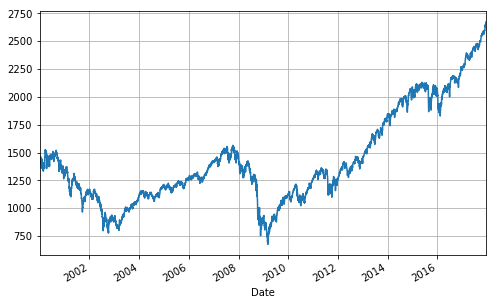

In [26]:
sp500['Close'].plot(grid=True, figsize=(8, 5))

In [27]:
sp500['42d']  = np.round(sp500['Close'].rolling(window=42 ,center=False).mean(), 2)
sp500['252d'] = np.round(sp500['Close'].rolling(window=252,center=False).mean(), 2)

In [28]:
sp500.tail()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-12-11  2652.189941  2660.330078  2651.469971  2659.989990  2659.989990   
2017-12-12  2661.729980  2669.719971  2659.780029  2664.110107  2664.110107   
2017-12-13  2667.590088  2671.879883  2662.850098  2662.850098  2662.850098   
2017-12-14  2665.870117  2668.090088  2652.010010  2652.010010  2652.010010   
2017-12-15  2660.629883  2679.629883  2659.139893  2675.810059  2675.810059   

                Volume      42d     252d  
Date                                      
2017-12-11  3091950000  2591.79  2426.80  
2017-12-12  3555680000  2594.48  2428.41  
2017-12-13  3542370000  2597.10  2429.96  
2017-12-14  3430030000  2599.34  2431.55  
2017-12-15  3745745599  2602.12  2433.19

In [29]:
sp500[['Close', '42d', '252d']].plot(grid=True, figsize=(8, 5))

In [30]:
sp500['42-252'] = sp500['42d'] - sp500['252d']
sp500['42-252'].tail()

Date
2017-12-11    164.99
2017-12-12    166.07
2017-12-13    167.14
2017-12-14    167.79
2017-12-15    168.93
Name: 42-252, dtype: float64

In [31]:
sp500['42-252'].head()

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
Name: 42-252, dtype: float64

In [32]:
SD = 50
sp500['Regime'] = np.where(sp500['42-252'] > SD, 1, 0)
sp500['Regime'] = np.where(sp500['42-252'] < -SD, -1, sp500['Regime'])
sp500['Regime'].value_counts()

 1    2191
 0    1378
-1     950
Name: Regime, dtype: int64

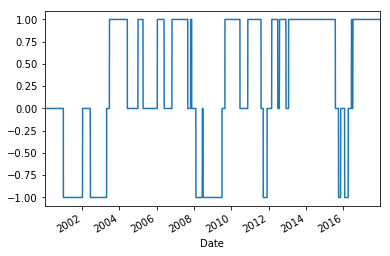

In [33]:
sp500['Regime'].plot(lw=1.5)

In [34]:
# market return
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
# while in a specific regime, long or short the market
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']

sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(8, 5))

The previous graph shows the cumulative log returns (compute using exponentials) over the period, the graph shows that this strategy (with its simplications) would have outperformed the market over the period.